<a href="https://colab.research.google.com/github/SonGoku27/Klimat/blob/main/Climat_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ удовлетворенности клиентов. Исследование комфорта при работе климатического оборудования.
### Описание проекта:
Вы работаете аналитиком в международной компании, занимающейся производством и продажами климатического оборудования: систем кондиционирования и вентиляции. На одной из выставок, посвященной климатическому оборудованию, группа инженеров из дружественной компании предоставила результаты своего исследования: данные по использованию климатических систем в офисах разных стран, городов, а также оценочные данные от респондентов по тому, насколько им комфортно было находиться в заданных условиях.                                                
  ** Руководство поставило вам задачу проанализировать полученные данные и предоставить выводы о том, в какой тип климатического оборудования стоит инвестировать больше, чтобы повысить удовлетворенность клиентов созданными условиями в зависимости от региона? И на что стоит обратить внимание при развитии бизнеса в разных регионах? **


In [124]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.stats as stats
from numpy.linalg import lstsq

# импорты для регресионного моделирования
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

df = pd.read_csv('/content/drive/MyDrive/yandex_data/data_1.csv', sep=";")

# Исследование данных на качество и предобработка
# Проведение расчётов и исследований Амир (Origami)


1. Приведение названий столбцов в соответствии с PEP8

In [125]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

2. Перевод данных к правильному типу             
Столбец "год" является типом float.                
Приведем к правильному типу, изменив его на int

In [126]:
print(df['год'].dtypes)
df['год'] = df['год'].astype('int')
print(df['год'].dtypes)

float64
int64


3. удаление дубликатов(категориальных данных)


In [127]:
df_no_duplicates = df.drop_duplicates(
    subset=['время_года', 'способ_охлаждения', 'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'пол',
            'ощущение_температуры_(bool)', 'предпочтительное_изменение_температуры', 'ощущение_движения_воздуха_(bool)',
            'предпочтительное_изменение_движения_воздуха', 'занавески', 'вентилятор',
            'окно', 'двери', 'отопление'],
    keep=False)


 4.1 Обработка данных на адекватность данных

 При заполнении данных были совершены опечатки:
 * В столбце "климат" - "Субтроп океанич" вместо "Субтропический океанический"
 * В столбце "способ_охлаждения" - "Тепле" вместо "Теплее"
 * В столбце "способ_охлаждения" - "Холодн" вместо "Холоднее"              
 Исправим их методом loc

In [128]:
df.loc[df['климат'] == 'Субтроп океанич', 'климат'] = 'Субтропический океанический'
df.loc[df['способ_охлаждения'] == 'Тепле', 'способ_охлаждения'] = 'Теплее'
df.loc[df['способ_охлаждения'] == 'Холодн', 'способ_охлаждения'] = 'Холоднее'

4.2 Обработка данных на выбросы          
Были найдены выбросы в столбцах: утепление, температура_воздуха_в_помещении, скорость_воздуха, рост, среднемесячная_температура_на_улице.
Расмотрим их на графиках:
Для обработки выбрасов нужно всем пропуски в таблице "пол" заменить на "Пол не указан"
* Создадим функцию emissions, которая будет отчищать данные от выбросов

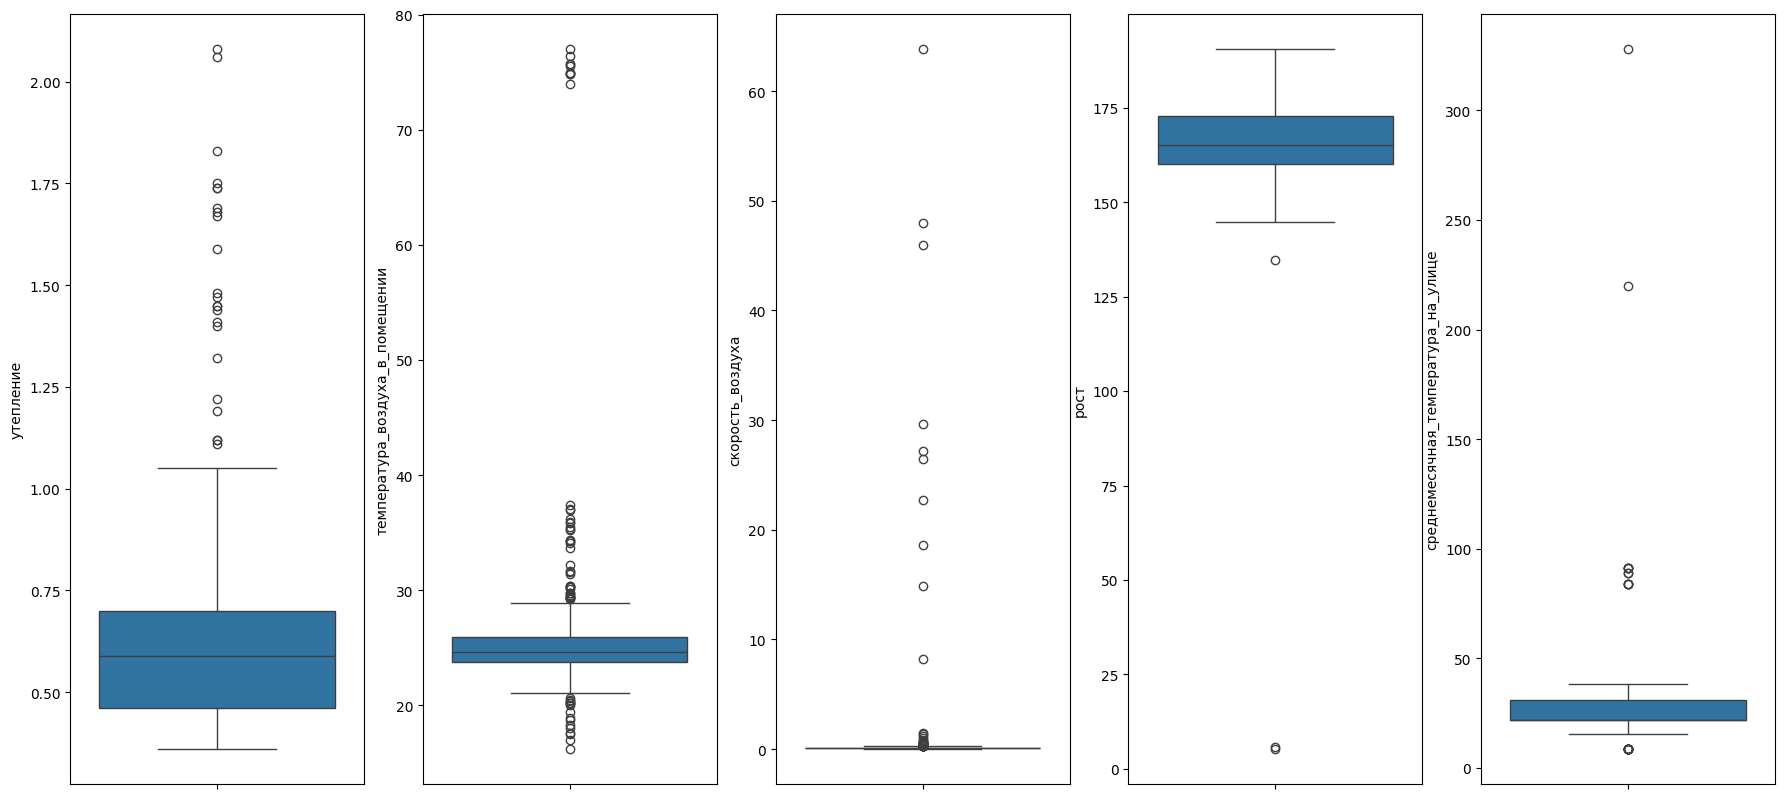

In [129]:
f, a = plt.subplots(1, 5, figsize=(22, 10))
for n, i in enumerate(['утепление', 'температура_воздуха_в_помещении', 'скорость_воздуха', 'рост',
                       'среднемесячная_температура_на_улице']):
    sns.boxplot(y=df[i], ax=a[n])
plt.savefig('zxc.png') # посмотрим на изображение "ВЫбросы.png"

# Для обработки выбрасов нужно всем пропуски в таблице "пол" заменить на "Пол не указан"
df['пол'] = df['пол'].fillna('Пол не указан')

In [130]:
def emissions(zxc):
    # Методом 3IQR для работы с выбросами.
    for i in ['утепление', 'температура_воздуха_в_помещении', 'скорость_воздуха', 'рост',
              'среднемесячная_температура_на_улице']:
        Q1, Q3 = zxc[i].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        zxc = zxc[(zxc[i] >= Q1 - 3 * IQR) & (zxc[i] <= Q3 + 3 * IQR)]
    return zxc
df[['утепление', 'температура_воздуха_в_помещении', 'скорость_воздуха', 'рост',
    'среднемесячная_температура_на_улице']] = emissions(df[['утепление', 'температура_воздуха_в_помещении',
                                                            'скорость_воздуха', 'рост',
                                                            'среднемесячная_температура_на_улице']])

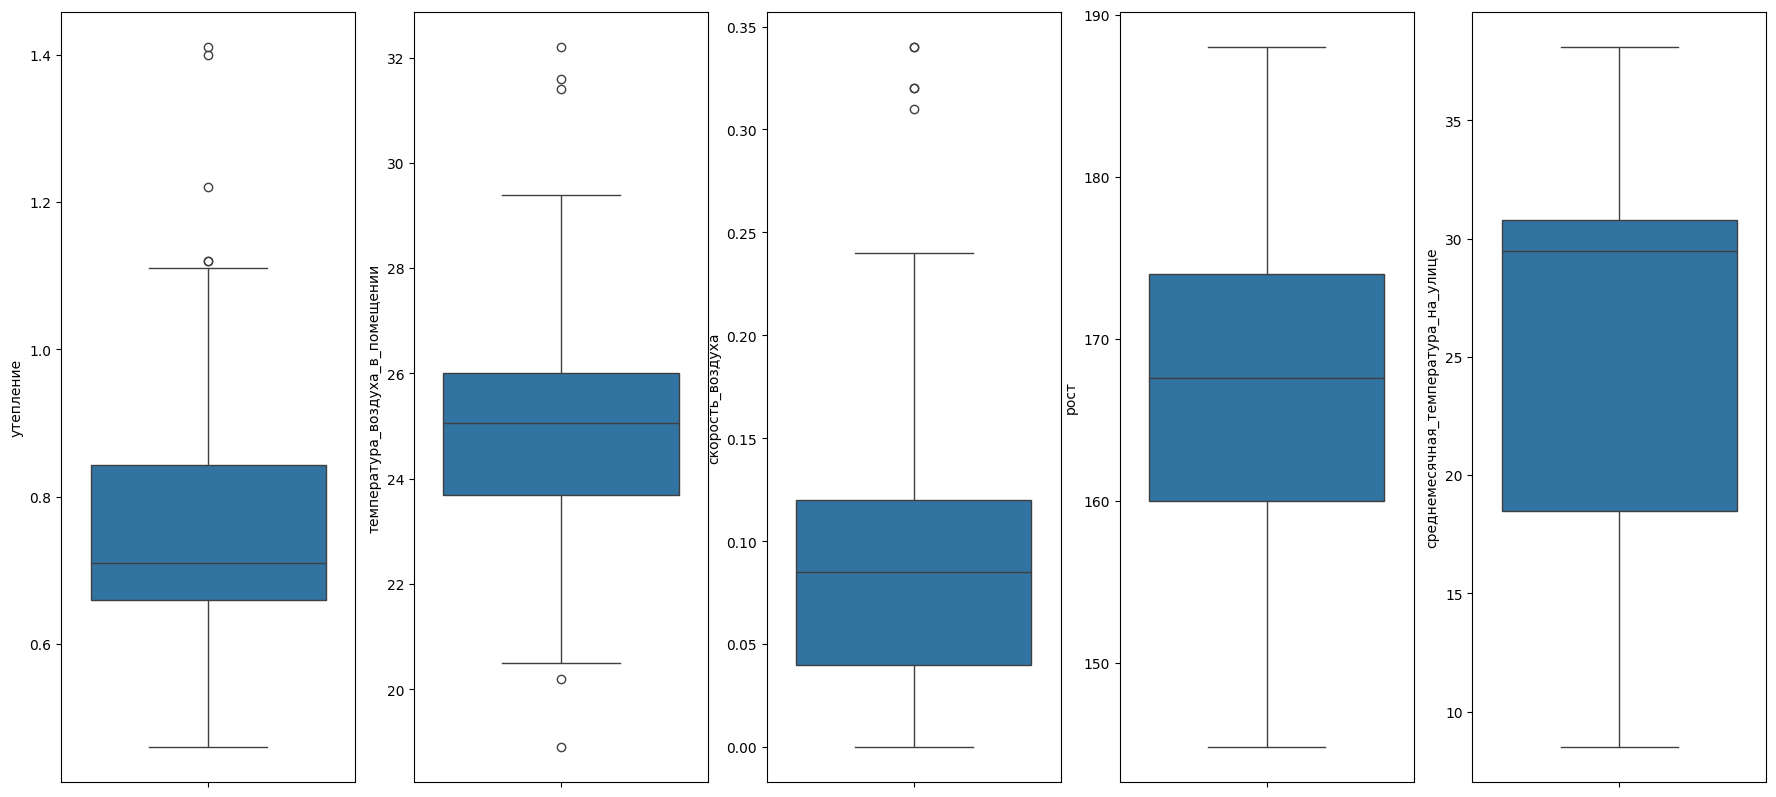

In [131]:
f, a = plt.subplots(1, 5, figsize=(22, 10))
for n, i in enumerate(['утепление', 'температура_воздуха_в_помещении', 'скорость_воздуха', 'рост',
                       'среднемесячная_температура_на_улице']):
    sns.boxplot(y=df[i], ax=a[n])
plt.savefig('zxc2.png')

Проанализировав график на картинке (klimat.png) можно сделать вывод, что кондиционирования зависит от состояния окна.
Только в случае когда окно закрыто используется способ охлаждения "Кондиционирования".


5.обработка пропусков
 * Заполним пропуски необходимых нам столбцах. Столбцы "Вес" и "Рост" мы заменим медианным значением, учитывая пол респондента.
 * Так как у многих респондентов столцеб "Пол" полностью отсутствует(пропуски в столбеце "Пол" не могут обработаны), мы заполнили его значением "Пол не указан".
 * Респондентов с данным значением в столбце "Пол", мы заполним общей медианной столбца.
 * Столбец "оценка_комфорта" мы заменим медианным значением, учитывая способ охлаждения респондента.

In [132]:
print(df['рост'])
# 1
for i in ['Женский', 'Мужской']:
    df.loc[((df['пол'] == i) & (df['вес'].isnull())), 'вес'] = df['вес'].fillna(df['вес'].describe().median())
    df.loc[((df['пол'] == i) & (df['рост'].isnull())), 'рост'] = df['рост'].fillna(df['рост'].describe().median())
df.loc[df['пол'] == 'Пол не указан', 'рост'] = df['рост'].fillna(df['рост'].describe().median())

# 2
for j in ['Кондиционирование', 'Вентиляция', 'Смешанный', 'NA']:  # зависит от способа охлаждения
    df.loc[((df['способ_охлаждения'] == j) & (df['оценка_комфорта'].isnull())), 'оценка_комфорта'] = (
        df['оценка_комфорта'].fillna(df['оценка_комфорта'].describe().mean()))
    df.loc[((df['способ_охлаждения'] == j) & (df['температура_воздуха_в_помещении'].isnull())),
    'температура_воздуха_в_помещении'] = (df['температура_воздуха_в_помещении'].fillna(
        df['температура_воздуха_в_помещении'].describe().mean()))


df1 = df  # рабочий момент :) :) :) :)


0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
       ...  
479    172.7
480      NaN
481      NaN
482      NaN
483      NaN
Name: рост, Length: 484, dtype: float64


Дополнительный категориальный столбец - количество_рекламаций_категории   
Создаем функцию для создания нового столбца "количество_рекламаций_кат" (Категириальный тип данных)


In [133]:
def qwe(x):
    if x <= 1:
        return 'мало'
    elif x == 2:
        return 'средне'
    elif x > 2:
        return 'много'


df1['количество_рекламаций_кат'] = [qwe(i) for i in df1['количество_рекламаций']]

дополнительный категориальный столбец - возраст_категории

Создаем функцию для создания нового столбца "возраст_кат" (Категириальный тип данных)

In [134]:
def zxc(z):
    if z <= 44:
        return 'молодой возраст'
    elif 45 <= z <= 59:
        return 'средний возраст'
    elif z > 60:
        return 'пожилой возраст'


df1['возраст_кат'] = [zxc(i) for i in df1['возраст']]


средний возраст респондентов по полу и стране

In [135]:
df1[['страна', 'пол', 'возраст']].groupby(['страна', 'пол']).mean()

возраст
страна    пол                     
Австралия Женский        46.348315
          Мужской        42.614679
Индия     Женский        36.590909
          Мужской        38.333333
США       Пол не указан  36.208333

Рассчитать среднюю комфортную температуру в зависимости от возрастной категории

Так как не указано какой комфортной температуры воздуха идет речь, мы возьмем комфортную температуру в помещении

Рассчет средней комфортной температуры в зависимости от возрастной категории

In [136]:
df3 = df1[['температура_воздуха_в_помещении', 'оценка_комфорта', 'возраст_кат']]
df3 = df3.loc[df3['оценка_комфорта'] == 6]
q2 = df3.dropna().groupby(['возраст_кат', 'оценка_комфорта']).mean()
print(q2.round())

                                 температура_воздуха_в_помещении
возраст_кат     оценка_комфорта                                 
молодой возраст 6.0                                         28.0
пожилой возраст 6.0                                         43.0
средний возраст 6.0                                         30.0


Медианное значение температуры и влажности для каждого типа охлаждени

In [137]:
q3 = df1[['температура_воздуха_в_помещении', 'rh', 'способ_охлаждения']].groupby(['способ_охлаждения']).median()
print(q3.round())
print(df3.dropna().groupby(['возраст_кат', 'оценка_комфорта']).mean())

                   температура_воздуха_в_помещении    rh
способ_охлаждения                                       
Вентиляция                                    28.0  46.0
Кондиционирование                             32.0  42.0
Смешанный                                     46.0  56.0
                                 температура_воздуха_в_помещении
возраст_кат     оценка_комфорта                                 
молодой возраст 6.0                                    27.941458
пожилой возраст 6.0                                    43.080018
средний возраст 6.0                                    30.125879


## **Исследование комфортных условий в офисах в разных странах** Aiman

Цель: Определить, в какой тип климатического оборудования стоит инвестировать больше, чтобы повысить удовлетворённость клиентов. Понять климатические особенности разных регионов, оценить комфорт в офисах и найти закономерности.

Мы начинаем с загрузки данных, в которых содержатся измерения условий в офисах в разных странах, включая температуру, влажность, скорость воздуха, а также субъективные оценки комфорта.

**Подготовка данных**

In [138]:
# Добавляем возрастные группы по заданным интервалам
df1["Возрастная группа"] = pd.cut(
    df1["возраст"],
    bins=[0, 18, 30, 45, 60, 120],
    labels=["<18", "18-30", "30-45", "45-60", "60+"],
    right=False
)

# Разбиваем относительную влажность на категории
df1["rh_комфорт"] = pd.cut(
    df["rh"],
    bins=[0, 30, 60, 100],
    labels=["сухо", "комфорт", "влажно"],
    right=False
)

# Убираем пробелы в названиях способов охлаждения
df1["способ_охлаждения"] = df1["способ_охлаждения"].astype(str).str.strip()

Эти категории помогут нам анализировать предпочтения и комфорт среди разных возрастов и условий.

**Группировка по полу и возрасту. Средние значения**

In [139]:
# Группировка по стране
for country in df1["страна"].dropna().unique():
    df_country = df1[df1["страна"] == country].copy()

    summary = (
        df_country.dropna(subset=["пол", "возраст_кат", "температура_воздуха_в_помещении"])
        .groupby(["пол", "возраст_кат"], observed=True)
        .agg({
            "температура_воздуха_в_помещении": "mean",
            "температура_воздуха_на_улице": "mean",
            "rh": "mean"
        })
        .reset_index()
        .rename(columns={
            "температура_воздуха_в_помещении": "Средняя температура в помещении",
            "температура_воздуха_на_улице": "Средняя температура на улице",
            "rh": "Средняя влажность"
        })
    )

    display(summary)


,пол,возраст_кат,Средняя температура в помещении,Средняя температура на улице,Средняя влажность
0,Пол не указан,молодой возраст,32.122109,24.101667,38.995000
1,Пол не указан,средний возраст,32.122109,24.116667,38.808333


,пол,возраст_кат,Средняя температура в помещении,Средняя температура на улице,Средняя влажность
0,Женский,молодой возраст,46.492493,NaN,61.368000
1,Женский,пожилой возраст,46.492493,NaN,44.550000
2,Женский,средний возраст,46.492493,NaN,61.266071
3,Мужской,молодой возраст,46.492493,NaN,61.668889
4,Мужской,пожилой возраст,46.492493,NaN,64.366667
5,Мужской,средний возраст,46.492493,NaN,61.680328


,пол,возраст_кат,Средняя температура в помещении,Средняя температура на улице,Средняя влажность
0,Женский,молодой возраст,29.484556,NaN,51.279310
1,Женский,средний возраст,30.136335,NaN,49.940000
2,Мужской,молодой возраст,28.218744,NaN,52.818519
3,Мужской,пожилой возраст,43.080018,NaN,78.800000
4,Мужской,средний возраст,33.241249,NaN,52.761364


Эта таблица позволяет увидеть климатический комфорт внутри и снаружи помещения, а также различия между мужчинами и женщинами разных возрастов.

**Комфортная влажность: соответствие стандарту**

Согласно рекомендациям ASHRAE и ГОСТ, оптимальный уровень относительной влажности в помещениях: 30–60%.

In [140]:
# Оцениваем, соответствует ли RH стандарту комфорта
df["rh_стандарт"] = df["rh"].apply(lambda x: "В норме" if 30 <= x <= 60 else "Отклонение")

**Корреляционный анализ**

In [141]:
%matplotlib inline
corr_cols = [
    "температура_воздуха_в_помещении",
    "температура_воздуха_на_улице",
    "rh",
    "скорость_воздуха",
    "оценка_комфорта",
    "среднемесячная_температура_на_улице"
]
print(corr_cols)
print(df1["страна"].dropna().unique())
for country in df1["страна"].dropna().unique():
    print(f"\nОбрабатывается страна: {country}")
    df_country = df1[df1["страна"] == country].copy()
    corr_df = df_country[corr_cols].dropna()
    print(f"Размер данных после фильтрации: {corr_df.shape}")
    print(df[corr_cols].isna().sum())
    if not corr_df.empty:
        corr = corr_df.corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title(f"Корреляция ({country})")
        plt.tight_layout()
        plt.savefig(f"plots/correlation_{country}.png")  # Сохраняем до показа
        plt.show()
        plt.close()

['температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'оценка_комфорта', 'среднемесячная_температура_на_улице']
['США' 'Австралия' 'Индия']

Обрабатывается страна: США
Размер данных после фильтрации: (0, 6)
температура_воздуха_в_помещении          0
температура_воздуха_на_улице           412
rh                                       0
скорость_воздуха                       380
оценка_комфорта                          0
среднемесячная_температура_на_улице    380
dtype: int64

Обрабатывается страна: Австралия
Размер данных после фильтрации: (0, 6)
температура_воздуха_в_помещении          0
температура_воздуха_на_улице           412
rh                                       0
скорость_воздуха                       380
оценка_комфорта                          0
среднемесячная_температура_на_улице    380
dtype: int64

Обрабатывается страна: Индия
Размер данных после фильтрации: (0, 6)
температура_воздуха_в_помещении          0
температура_воздуха_на_ули

В большинстве стран наблюдается сильная положительная корреляция между температурой на улице и внутри офиса. Это означает, что системы охлаждения не всегда компенсируют внешний климат.

**Регрессионная модель: что влияет на внутреннюю температуру?**

In [158]:
for country in df1["страна"].dropna().unique():
    df_country = df1[df1["страна"] == country].copy()

    model_cols = [
        "температура_воздуха_в_помещении",
        "rh",
        "скорость_воздуха",
        "оценка_комфорта",
        "способ_охлаждения"
    ]
    df_model = df_country[model_cols].dropna()
    if not df_model.empty:
        X = pd.concat([
            df_model[["rh", "скорость_воздуха", "оценка_комфорта"]],
            pd.get_dummies(df_model["способ_охлаждения"], prefix="Охлаждение", dtype=float)
        ], axis=1)

        X = X.astype(float)
        y = df_model["температура_воздуха_в_помещении"].astype(float)
        X.insert(0, "Intercept", 1.0)

        beta = lstsq(X.values, y.values, rcond=None)[0]
        y_pred = X @ beta
        r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
        rmse = np.sqrt(np.mean((y - y_pred) ** 2))
        print(f"=== {country} ===")
        print("Коэффициенты регрессии:")
        for name, coef in zip(X.columns, beta):
            print(f"{name}: {coef:.3f}")
        print(f"R2: {r2:.4f}")
        print(f"RMSE: {rmse:.4f}")

hello
hello
hello
hello2
=== Индия ===
Коэффициенты регрессии:
Intercept: 17.673
rh: -0.012
скорость_воздуха: 16.614
оценка_комфорта: 0.082
Охлаждение_Вентиляция: 6.130
Охлаждение_Кондиционирование: 5.347
Охлаждение_Смешанный: 6.196
R2: 0.3336
RMSE: 1.7552


Интерпретация:

Большие значения R² (близкие к 1) говорят о плохом качестве модели.
Кроме этой есть еще две модели ниже

**Выводы**

1. Температура в офисе часто зависит от температуры на улице, особенно в странах с жарким климатом.
2. Влажность во многих случаях отклоняется от рекомендованной — важно инвестировать в увлажнители/осушители воздуха.
3. Тип охлаждения (например, центральный кондиционер, вентиляция и т.д.) имеет разный эффект в зависимости от региона.
4. Рекомендация: Инвестировать больше в региональные решения, например, мощное кондиционирование в жарких странах и системы вентиляции с контролем влажности в странах с колебаниями влажности.

# Проверка гипотез Neon

### Есть ли взаимосвязь между количеством рекламаций и оценкой комфорта?
-  Н0: Взаимосвязь между количеством рекламаций и оценкой комфорта нет.
-  Н1: Взаимосвязи между количеством рекламаций и оценкой комфорта есть.

Есть отрицательная корреляция и она точно не случайна так как p-value = 0.     
Так как взаимосвязь есть отклоняем нулевую гипотезу.

In [143]:
# тест на нормальность
stat, p_value = stats.shapiro(df1['количество_рекламаций'])
print(f"p-value: {p_value:.5f} ")  # данные не нормальные
stat, p_value = stats.shapiro(df1['оценка_комфорта'])
print(f"p-value: {p_value:.5f} ") # данные не нормальные

# Коэффициент корреляции Спирмена
corr, p_value = stats.spearmanr( df1['количество_рекламаций'], df1['оценка_комфорта'])
print(f'Корреляция: {round(corr, 3)}, p-value: {round(p_value, 5)}')


p-value: 0.00000 
p-value: 0.00000 
Корреляция: -0.426, p-value: 0.0


### Проверить гипотезу о том, что средняя оценка комфорта отличается в зависимости от страны
- Н0: Средняя оценка комфорта не отличается в зависимости от страны.
- Н1: Средняя оценка комфорта отличается в зависимости от страны.               
  Исходя из этих данных можем отклонить вторую гипотезу и принять первую. Т.е,
  Средняя оценка комфорта действительно отличается в зависимости от странны. Также можем наблюдать значительно низкое среднее значение в США относительно других стран.

In [144]:
print(df1.groupby('страна')['оценка_комфорта'].mean())


groups = [group['оценка_комфорта'].values for name, group in df1.groupby('страна')]
# Применим Kruskel Wallis
f_stat, p_value = stats.kruskal(*groups)
print(f"\n H-число: {round(f_stat,3)}, p-value: {round(p_value, 5)}")


страна
Австралия    30.379157
Индия        13.462244
США           4.194444
Name: оценка_комфорта, dtype: float64

 H-число: 288.961, p-value: 0.0


Проверить гипотезу "Влияет ли способ охлаждения на оценку комфорта?"
* Н0: способ охлаждения не влияет на оценку комфорта.
* Н1: способ охлаждения влияет на оценку комфорта

Результаты отклоняют нулевую гипотезу , способ охлаждения влияет на оценку комфорта, но различия минимальны .

In [145]:
# тест на нормальность
for name, group in df1.groupby('способ_охлаждения'):
    stat, p = stats.shapiro(group['оценка_комфорта'])
    print(f"Способ охлаждения: {name}, p-value = {p:.5f}") # данные не нормальные

# Применим Краскел Уолис
groups = [group['оценка_комфорта'].values for name, group in df.groupby('способ_охлаждения')]
h_stat, p_value = stats.kruskal(*groups)
print(f"\nH-статистика: {h_stat:.3f}, p-value: {p_value:.5f}")

Способ охлаждения: Вентиляция, p-value = 0.00000
Способ охлаждения: Кондиционирование, p-value = 0.00000
Способ охлаждения: Смешанный, p-value = 0.00000

H-статистика: 246.040, p-value: 0.00000


Проверить гипотезу "Влияет ли пол на оценку комфорта?"
* Н0: пол не влияет на оценку комфорта.
* Н1: пол влияет на оценку комфорта

Результаты не дают нам оснований отклонять нулевую гипотезу. Следовательно пол не влияет на оценку комфорта.

In [146]:
# тест на нормальность
for name, group in df1.groupby('пол'):
    stat, p = stats.shapiro(group['оценка_комфорта'])
    print(f"Пол: {name}, p-value = {p:.5f}") # данные не нормальные

# Применим метод Манна Уитни
group_male = df1[df1['пол'] == 'Мужской']['оценка_комфорта'].values
group_female = df1[df1['пол'] == 'Женский']['оценка_комфорта'].values
stat, p = stats.mannwhitneyu(group_male, group_female, alternative='two-sided')
print(f"U-статистика: {stat:.3f}, p-value: {p:.5f}")


Пол: Женский, p-value = 0.00000
Пол: Мужской, p-value = 0.00000
Пол: Пол не указан, p-value = 0.00107
U-статистика: 18162.500, p-value: 0.05565


Проверить гипотезу "Влияет ли возрастная группа на оценку комфорта?"
* Н0: возрастная группа не влияет на оценку комфорта.
* Н1: возрастная группа влияет на оценку комфорта

Результаты не дают нам оснований отклонять нулевую гипотезу. Следовательно  возрастная группа не влияет на оценку комфорта.

In [147]:
column_names = df1.columns.tolist()
# тест на нормальность
for name, group in df1.groupby('возраст_кат'):
    stat, p = stats.shapiro(group['оценка_комфорта'])
    print(f"Возрастная группа: {name}, p-value = {p:.5f}") # данные не нормальные

# разделение на
young = df1[df1['возраст_кат'] == 'молодой возраст']['оценка_комфорта']
middle = df1[df1['возраст_кат'] == 'средний возраст']['оценка_комфорта']
old = df1[df1['возраст_кат'] == 'пожилой возраст']['оценка_комфорта']

# Kruskal–Wallis test
stat, p = stats.kruskal(young, middle, old)
print(f"Kruskal–Wallis H = {stat:.4f}, p-value = {p:.5f}")

Возрастная группа: молодой возраст, p-value = 0.00000
Возрастная группа: пожилой возраст, p-value = 0.00000
Возрастная группа: средний возраст, p-value = 0.00000
Kruskal–Wallis H = 51.8583, p-value = 0.00000


Проверить гипотезу "Проверить гипотезу влияет ли климат на оценку комфорта"
* Н0: климат не влияет на оценку комфорта.
* Н1: климат влияет на оценку комфорта

Результаты дают основание отклонить нулевую гипотезу и принять альтернативную.
Климат влияет на оценку комфорта,

In [148]:
# тест на нормальность
for name, group in df1.groupby('климат'):
    stat, p = stats.shapiro(group['оценка_комфорта'])
    print(f"Климат: {name}, p-value = {p:.5f}") # данные не нормальные

# Применим Kruskil wallis test
groups = [group['оценка_комфорта'].values for _, group in df1.groupby('климат')]
f_stat, p_value = stats.f_oneway(*groups)
print(f"\nF-статистика: {f_stat:.3f}, p-value: {p_value:.5f}" )


Климат: Cубтроп океанич, p-value = nan
Климат: Cубтропический океанический, p-value = 0.00000
Климат: Влажный субтропический муссонный, p-value = 0.00001
Климат: Жаркий полузасушливый, p-value = 0.00000
Климат: Субтропическое высокогорье, p-value = 0.00000
Климат: Тропическая влажная саванна, p-value = 0.00000

F-статистика: 30.425, p-value: 0.00000


<ipython-input-148-dd36ee489a0c>:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = stats.shapiro(group['оценка_комфорта'])


Проверить гипотезу "Проверить гипотезу влияет ли время года на оценку комфорта"
* Н0: время года не влияет на оценку комфорта.
* Н1: время года влияет на оценку комфорта

Результаты (p-value ≥ 0.05) дают основание принять нулевую гипотезу , и показывают что различия статистически не значимы

In [149]:
# тест на нормальность
for name, group in df1.groupby('время_года'):
    stat, p = stats.shapiro(group['оценка_комфорта'])
    print(f"Время года: {name}, p-value = {p:.5f}") # данные не нормальные

# Применим метод краскела уолиса
groups = [group['оценка_комфорта'].values for _, group in df1.groupby('время_года')]
stat, p_value = stats.kruskal(*groups)

print(f"\nKruskal-Wallis H-статистика: {stat:.3f}, p-value: {p_value:.5f}\n")



Время года: Весна, p-value = 1.00000
Время года: Зима, p-value = 0.00000
Время года: Лето, p-value = 0.00000
Время года: Осень, p-value = 1.00000

Kruskal-Wallis H-статистика: 32.407, p-value: 0.00000



/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Проверить гипотезу "Хотят ли мужчины и женщины разного изменения температуры / движения воздуха?"
* Н0: Мужчины и женщины не хотят разного изменения движения воздуха?
* Н1: Мужчины и женщины  хотят разного изменения движения воздуха?              
Результаты p ≥ 0.05  Нет статистически значимой связи между полом и предпочтениями. Придерживаемся нулевой гипотезы


In [150]:
contingency_table = pd.crosstab(df['пол'], df['предпочтительное_изменение_движения_воздуха'])
print(contingency_table)
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"X2 = {chi2:.4f}, p-value = {p:.5f}")

предпочтительное_изменение_движения_воздуха  Без изменений  Больше  Меньше
пол                                                                       
Женский                                                 94      52      12
Мужской                                                157      89       8
Пол не указан                                           40      20      12
X2 = 17.1245, p-value = 0.00183


##Выводы
* Средняя оценка комфорта  отличается в зависимости от странны. Также можем наблюдать значительно низкое среднее значение в США относительно других стран.
* Способ охлаждения влияет на оценку комфорта , но различия минимальны.
* Пол не влияет на оценку комфорта.
* Возрастная группа не влияет на оценку комфорта.
* Климат влияет на оценку комфорта,
* Время года не влияет на оценку комфорта.
* Мужчины и женщины не хотят разного изменения движения воздуха


В США применяется исключительно кондиционированный тип охлаждения, который демонстрирует низкий уровень удовлетворённости  num . Это указывает на необходимость оптимизации данного типа системы в аналогичных регионах с близким климатом.
В Индии присутствуют разные типы климатических систем, что позволило провести сравнительный анализ.  
Наивысший уровень комфорта был достигнут при использовании кондиционированного тип охлаждения  — 5.6, в то время как   вентиляционный тип показывал 5.15 , а смешанный тип самое низкое число 4.93
Это указывает на перспективность инвестиций в кондиционированный тип охлаждения для регионов с похожими климатическими условиями.

# Регрессионное моделирование Neon
Построить регрессионную модель температуры воздуха в помещении в зависимости от типа охлаждения и других значимых факторов. Выбор факторов - на усмотрение исполнителя.                                                                    
Выбранные факторы кроме основных:     
 * время_года
 * отопление
 * среднемесячная_температура_на_улице
 * климат                                                                      
  Эти факторы были отобраны потому, что логически должны оказывать влияние на температуру внутри помещения

    
  Первая версия, с помощью линейной регрессии

  

In [151]:
# Выбираем признаки и целевую переменную
X = df1[['способ_охлаждения', 'время_года','отопление', 'среднемесячная_температура_на_улице', 'климат' ] ]
         #'окно', 'двери'
y = df1['температура_воздуха_в_помещении']

numeric_features = ['среднемесячная_температура_на_улице']
categorical_features = [
    'время_года',
    'способ_охлаждения',
    'отопление',
    'климат'
    # 'окно', 'двери'
]



# Препроцессор: OneHotEncoder + StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        # ('num', StandardScaler(), numeric_features)
    ]
)

# Модельный пайплайн: сначала преобразование, потом регрессия
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regression', LinearRegression())
])

# Делим на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение
pipeline.fit(X_train, y_train)

# Предсказание
y_pred = pipeline.predict(X_test)
# Метрики
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred) ** 0.5)

R²: 0.8058002656135229
RMSE: 4.152511457134157


Вторая версия с помощью RandomForestRegressor

In [152]:
# Выбираем признаки и целевую переменную
X = df1[['способ_охлаждения', 'время_года','отопление', 'среднемесячная_температура_на_улице']]
         #'окно', 'двери'
y = df1['температура_воздуха_в_помещении']

numeric_features = ['среднемесячная_температура_на_улице']
categorical_features = [
    'время_года',
    'способ_охлаждения',
    'отопление',
    #'окно', 'двери'
]

# Преобразование признаков
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    # ('num', StandardScaler(), numeric_features)
])

# Пайплайн с RandomForest
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказание
y_pred = pipeline.predict(X_test)

# Оценка модели
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mae = mean_absolute_error(y_test, y_pred)

# Вывод результатов
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


R²: 0.7993
RMSE: 4.2210
MAE: 2.4288


In [153]:
avg_df = df1.groupby('город', as_index=False)['оценка_комфорта'].mean()
top_city = avg_df.loc[avg_df['оценка_комфорта'].idxmax()]
print(top_city)

город                 Сидней
оценка_комфорта    30.379157
Name: 3, dtype: object


### Как итог этого раздела

С помощью регрессионого моделирования былы созданы две модели. Метрики показывают  результы предсказания модели плохие , и их пока нельзя использовать в реальных ситуациях , т.к средняя ошибка в 7 градусов ужасно высокая. Это в основном из за малого количества данных , при большом количестве факторов . В будущем после сбора более значительных данных , планируется заного переобучить модели и затем использовать их в реальных ситуациях